# empty pred_str 확인

In [ ]:
import pandas as pd
data = pd.read_csv("./mike2.csv")
for i in range(4871):
    file = str(data.loc[i]['image_id'])
    num = int(file[5:9])
    if num != i:
        print(i, file)

# confidence score filtering

In [62]:
from ensemble_boxes import *
import pandas as pd
import numpy as np

data = pd.read_csv("./betty2.csv")
conf_thr = 0.1

for _, row in data.iterrows():
    pred_str = row['PredictionString']
    if str(type(pred_str)) != "<class 'str'>":
        continue
    pred = np.array(pred_str.strip().split(" ")).reshape(-1,6)
    box = pred[:, 2:].astype(np.float64)  # 0~1 normalize
    score = pred[:, 1].astype(np.float64).flatten()
    label = pred[:, 0].astype(np.int64).flatten()
    
    box = box[score >= conf_thr]
    label = label[score >= conf_thr]
    score = score[score >= conf_thr]

    prediction_string = ""
    for i in range(len(box)):
        prediction_string += str(int(label[i])) + ' ' + str(score[i]) + ' ' + str(box[i][0]) + ' ' + str(box[i][1]) + ' ' + str(box[i][2]) + ' ' + str(box[i][3]) + ' '
    row['PredictionString'] = prediction_string


data.to_csv("./betty2_filterConf.csv", index=None)
data.head()
    

,PredictionString,image_id
0,0 0.23156068 495.20093 595.97046 551.58575 644...,test/0000.jpg
1,0 0.3851502 638.32806 648.2826 685.13116 842.2...,test/0001.jpg
2,0 0.8441453 879.4398 464.67267 1024.0 637.0589...,test/0002.jpg
3,0 0.26585767 0.88066405 0.0 1024.0 1024.0 0 0....,test/0003.jpg
4,0 0.6532128 186.6841 248.41743 876.11084 778.9...,test/0004.jpg


# ensemble

In [87]:
from ensemble_boxes import *
import pandas as pd
import numpy as np

save = "./ensemble10.csv"
predictions = []
predictions.append(pd.read_csv("./sandy_ensemble.csv"))
predictions.append(pd.read_csv("./mike_ensemble2.csv"))
predictions.append(pd.read_csv("./betty_ensemble.csv"))
#predictions.append(pd.read_csv("./ellie.csv"))


prediction_strings = []
file_names = []

for img_idx in range(len(predictions[0])):

    boxes_list = []
    scores_list = []
    labels_list = []

    for model_idx in range(len(predictions)): 
        pred_str = predictions[model_idx].loc[img_idx]['PredictionString']
        if str(type(pred_str)) != "<class 'str'>":
            continue
        else:
            pred = np.array(pred_str.strip().split(" ")).reshape(-1,6)

            box = pred[:, 2:].astype(np.float64)/1024  # 0~1 normalize
            score = pred[:, 1].astype(np.float64).flatten()
            label = pred[:, 0].astype(np.int64).flatten()

        boxes_list.append(box)
        scores_list.append(score)
        labels_list.append(label)
    
    if len(boxes_list) == 0:
        prediction_strings.append("")
        file_names.append(predictions[model_idx].loc[img_idx]["image_id"])
        continue
    
    boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=0.55)

    #category로 정렬
    sorted_data = sorted(zip(labels.tolist(), boxes.tolist(), scores.tolist()))
    sorted_labels, sorted_boxes, sorted_scores = zip(*sorted_data)

    prediction_string = ""
    for i in range(len(boxes)):
        prediction_string += str(int(sorted_labels[i])) + ' ' + str(sorted_scores[i]) + ' ' + str(sorted_boxes[i][0]*1024) + ' ' + str(sorted_boxes[i][1]*1024) + ' ' + str(sorted_boxes[i][2]*1024) + ' ' + str(sorted_boxes[i][3]*1024) + ' '
    prediction_strings.append(prediction_string)
    file_names.append(predictions[model_idx].loc[img_idx]["image_id"])

submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(save, index=None)
submission.head()

c:\Users\hjjun\miniconda3\envs\workspace\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
c:\Users\hjjun\miniconda3\envs\workspace\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


,PredictionString,image_id
0,0 0.02414783333333333 155.0003712 453.999872 1...,test/0000.jpg
1,0 0.002193019666666667 624.71045 550.3635 736....,test/0001.jpg
2,0 0.03832542 5.1948705 239.08167 146.04373 367...,test/0002.jpg
3,0 0.08438494801521301 0.4624270498752594 2.374...,test/0003.jpg
4,0 0.31426218152046204 190.3715057373047 255.17...,test/0004.jpg


# Ensemble 확인

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor, ImageFont
import numpy as np


#files_name = ["ensemble7", "ensemble9", "ensemble10"]
files_name = ["sandy_ensemble", "mike_ensemble2", "betty_ensemble", "ellie", "ensemble9"]

files= []
for i in range(len(files_name)):
    files.append(pd.read_csv(f'./{files_name[i]}.csv'))

confidence score :  0.2465532473636363 0.9928905 0.016603803
confidence score :  0.21154663823463177 0.979778528213501 0.053439
confidence score :  0.27666263791930307 0.9425667524337769 0.05056297
confidence score :  0.5316553410000001 0.99861085 0.052868303
confidence score :  0.1177790553086784 0.976895272731781 0.00415095075


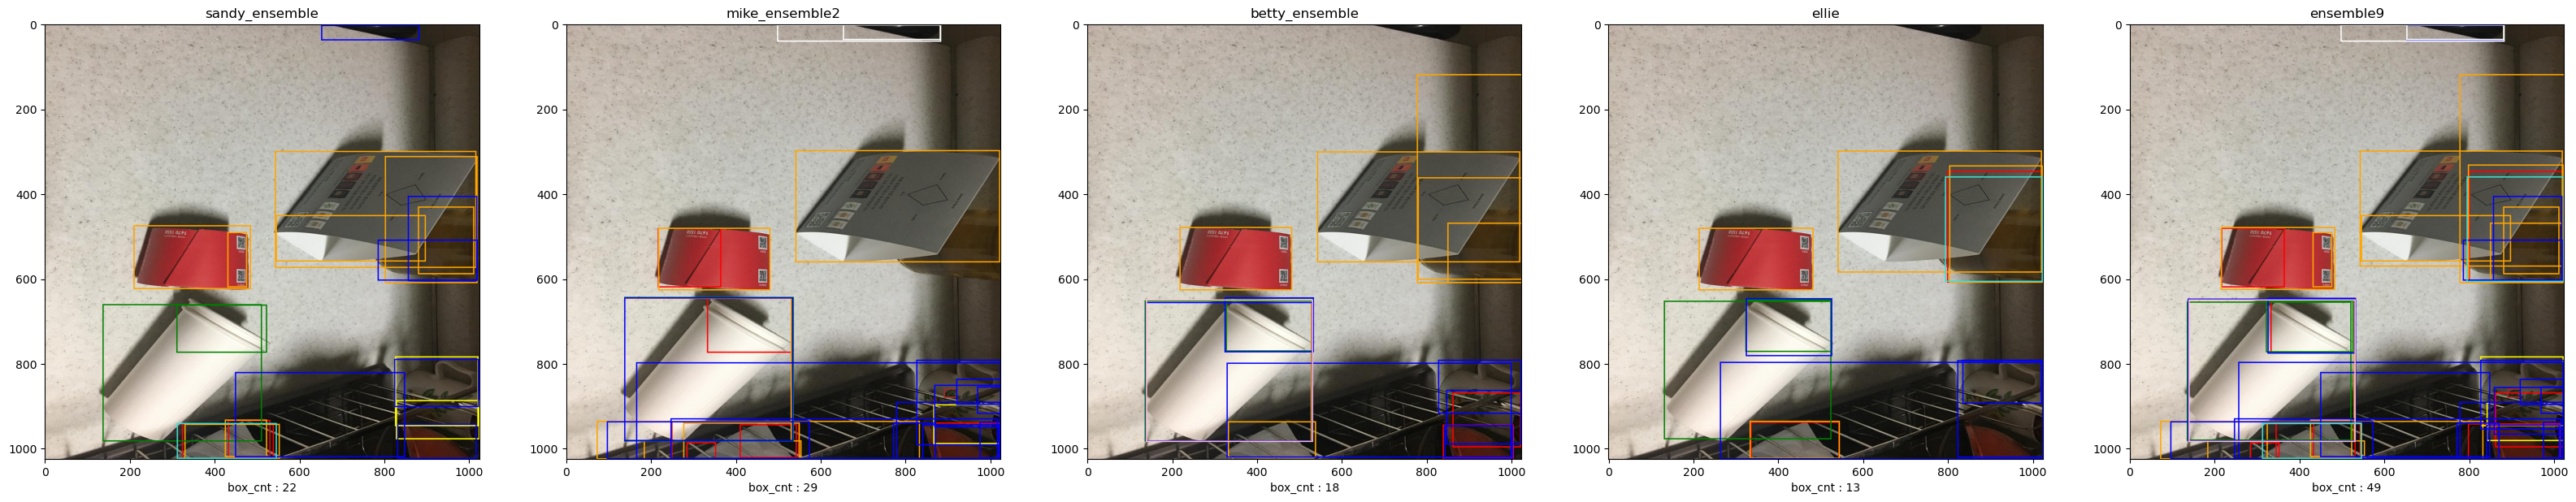

In [101]:
idx = 987
root = './dataset/'
colors = ["Red", "Orange", "Green", "Yellow", "Brown", "Blue", "Pink", "Turquoise", "Violet", "White"] 
categories = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

font = ImageFont.truetype("arial.ttf", 40) # arial.ttf 글씨체, font_size=15

plt.figure(figsize=(40,10))
for file_idx in range(len(files)):
    plt.subplot(1, len(files), file_idx+1)
    
    pred_str = files[file_idx].loc[idx]['PredictionString']
    img_id = files[file_idx].loc[idx]['image_id']

    preds = np.array(pred_str.strip().split(" ")).reshape(-1, 6)
    bboxes = preds[:, 2:].astype(np.float64)
    category = preds[:, 0].flatten().astype(np.int64)

    img = Image.open(root + img_id)
    draw = ImageDraw.Draw(img)
    for i, box in enumerate(bboxes):
        #if category[i] != 0:
        #    continue
        draw.rectangle((box[0], box[1], box[2], box[3]), outline = ImageColor.getrgb(colors[category[i]]), width=3)
        # draw.text((box[0], box[1] - 40 ), categories[category[i]], "Black", font=font)

    plt.imshow(img)
    plt.xlabel("box_cnt : " + str(len(bboxes)))
    plt.title(files_name[file_idx])
    confidence = preds[:, 1].flatten().astype(np.float64)
    print("confidence score : ", confidence.mean(), confidence.max(), confidence.min())
